<h1 > Offensive Language Classification </h1>


In [43]:
#import all necessary library
import pandas as pd
import langdetect
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm


In [6]:
#load all CSV file
train =pd.read_csv("../offence_data/train.csv")
test = pd.read_csv("../offence_data/test.csv")
valid = pd.read_csv("../offence_data/validation.csv") 
test_lebel = pd.read_csv("../offence_data/test_labels.csv") 


<h1 > just visualize train , test, validation data </h1>

In [7]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [8]:
valid.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


In [9]:
test.head()

,id,content,lang
0,56496,"Bahar merhaba, Şu TV programı için bildiğin gi...",tr
1,18266,"Merhaba, başlık taşıma nedeniyle bir karışıklı...",tr
2,37852,kullanıcı ne mutlu türküm diyene yazmış ta...,tr
3,25075,Quand la plaisanterie sur le synopsis de ce fi...,fr
4,330,Não fosse seu esclarecimento no blog da Anne (...,pt


In [10]:
test_lebel.head()

,id,toxic
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


<h2 style="color: green;"> adding test label into test data and drop where lebel is NAN  </h2>

In [11]:
test['Index'] = range(1, len(test) + 1)
test_lebel['Index'] = range(1, len(test_lebel) + 1)
test = test.merge(test_lebel[['Index', 'toxic']], on='Index', how='left')
test.drop('Index', axis=1, inplace=True)
test['toxic'] = test['toxic'].dropna()
test = test.dropna(subset=['toxic'])
test['toxic'] = test['toxic'].astype(int)
test = test.rename(columns={'content': 'feedback_text'})
print(test.tail(5))

         id                                      feedback_text lang  toxic
5995  62498  J’ajoute que vouloir « appréhender la personna...   fr      0
5996  13655  Merhaba. Vikipedi miz 150.000 maddeye ulaştı a...   tr      0
5997  57160   Ну по сути 2 раза. К тому же там претензии из...   ru      0
5998   2322  Ma asi es lo mismo, dando opcion a las otras d...   es      0
5999  15179   je dirais bien « va donc espèce de bufon » ma...   fr      0


<h1 style="color: green;"> Start EDA and Data manipulation   </h1>

In [12]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


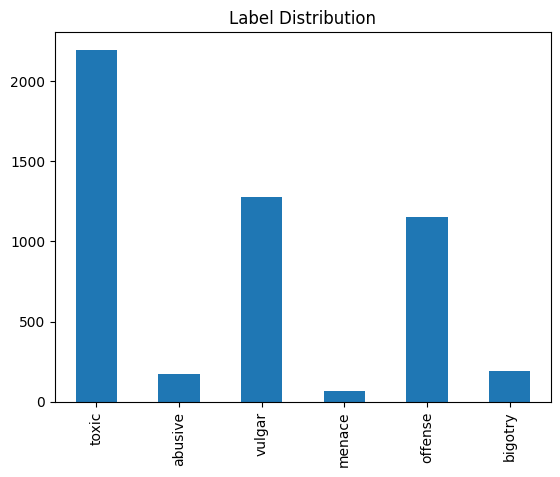

In [13]:
#Lebel destribuition chart
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
train[label_cols].sum().plot(kind="bar", title="Label Distribution")
plt.show()



<h1> Detect laguages present in train dataset </h1>

In [14]:
from langdetect import detect, LangDetectException
import pandas as pd

# Sample DataFrame (replace this with your real one)
# train = pd.read_csv('your_file.csv')

# Create a list to hold detected languages
detected_languages = []

# Iterate through each feedback text
for text in train['feedback_text']:
    if pd.isna(text):
        detected_languages.append(None)
    else:
        try:
            lang = detect(text)
            detected_languages.append(lang)
        except LangDetectException:
            detected_languages.append(None)  # Or use a default like 'unknown'

# Add the language column to the DataFrame
train['lang'] = detected_languages


In [15]:
print(train['lang'].isnull().sum())

4


In [16]:
train['lang'].unique()


array(['en', 'es', 'tl', 'no', 'de', 'fa', 'af', 'id', 'so', 'et', 'fr',
       'vi', 'sl', 'tr', 'pt', 'ro', 'sv', 'sw', 'hr', 'fi', 'nl', 'cy',
       'it', 'cs', 'da', 'ar', 'pl', 'bn', 'ca', 'hu', 'lt', 'sq', 'sk',
       'ru', 'he', 'ko', 'zh-cn', 'gu', 'ta', 'el', None, 'hi', 'th',
       'mk', 'ml', 'zh-tw', 'te', 'mr', 'bg'], dtype=object)

In [17]:
train = train.dropna(subset=['lang'])

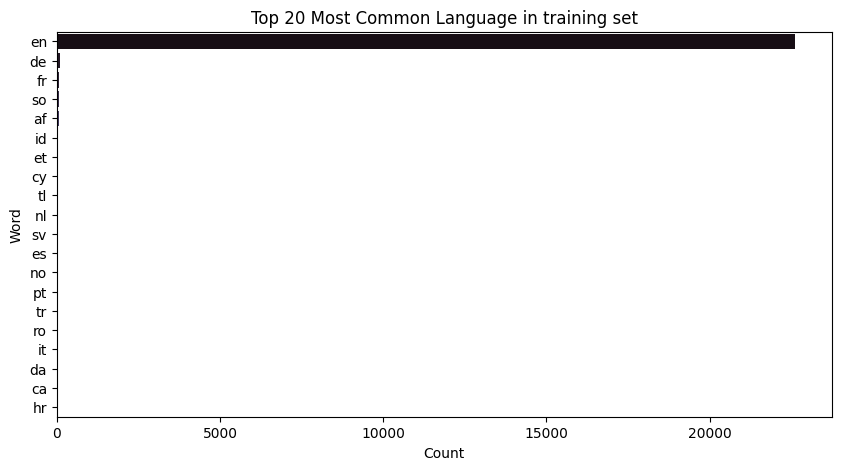

In [18]:
all_words = ' '.join(train['lang'].astype(str)).lower().split()


common_words = Counter(all_words)
common_words_df = pd.DataFrame(common_words.most_common(20), columns=['word', 'count'])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=common_words_df, x='count', y='word', palette='mako')
plt.title("Top 20 Most Common Language in training set")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

<h1>collecting multi langual stop word for further analisys </h1>

In [21]:

nltk.download('stopwords')

# List of language names (without language codes)
languages = [
    'english', 'spanish', 'tagalog', 'estonian', 'german', 'persian (farsi)', 'afrikaans',
    'norwegian', 'somali', 'indonesian', 'french', 'vietnamese', 'slovenian', 'turkish',
    'portuguese', 'romanian', 'swahili', 'croatian', 'danish', 'albanian', 'welsh', 'italian',
    'czech', 'swedish', 'finnish', 'dutch', 'arabic', 'polish', 'bengali', 'catalan', 'hungarian',
    'lithuanian', 'slovak', 'russian', 'hebrew', 'korean', 'chinese (simplified)', 'gujarati', 
    'tamil', 'greek', 'hindi', 'thai', 'latvian', 'macedonian', 'malayalam', 'chinese (traditional)',
    'telugu', 'marathi', 'bulgarian'
]

multi_stop_words = set()

# Loop through the list of languages and update the multi_stop_words set
for lang in languages:
    try:
        # Check if stopwords exist for the language
        if lang in stopwords.fileids():
            multi_stop_words.update(stopwords.words(lang))
        else:
            print(f"No stopwords available for: {lang}")
    except Exception as e:
        print(f"Error with language {lang}: {e}")

print(f"Collected {len(multi_stop_words)} stopwords.")



No stopwords available for: tagalog
No stopwords available for: estonian
No stopwords available for: persian (farsi)
No stopwords available for: afrikaans
No stopwords available for: somali
No stopwords available for: vietnamese
No stopwords available for: slovenian
No stopwords available for: swahili
No stopwords available for: croatian
No stopwords available for: welsh
No stopwords available for: czech
No stopwords available for: polish
No stopwords available for: lithuanian
No stopwords available for: slovak
No stopwords available for: korean
No stopwords available for: chinese (simplified)
No stopwords available for: gujarati
No stopwords available for: hindi
No stopwords available for: thai
No stopwords available for: latvian
No stopwords available for: macedonian
No stopwords available for: malayalam
No stopwords available for: chinese (traditional)
No stopwords available for: telugu
No stopwords available for: marathi
No stopwords available for: bulgarian
Collected 5292 stopword

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Missing values:
 id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
lang             0
word_count       0
char_count       0
dtype: int64


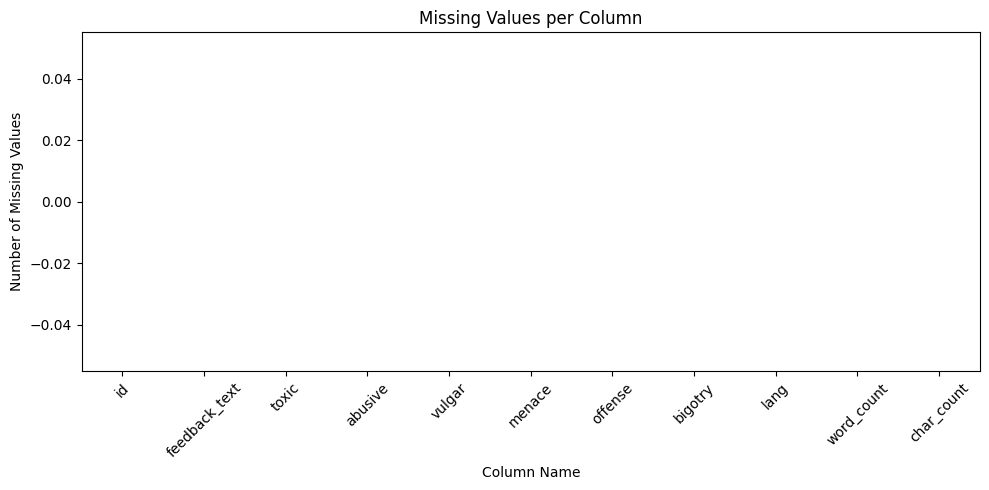


Rows with missing feedback_text: 0


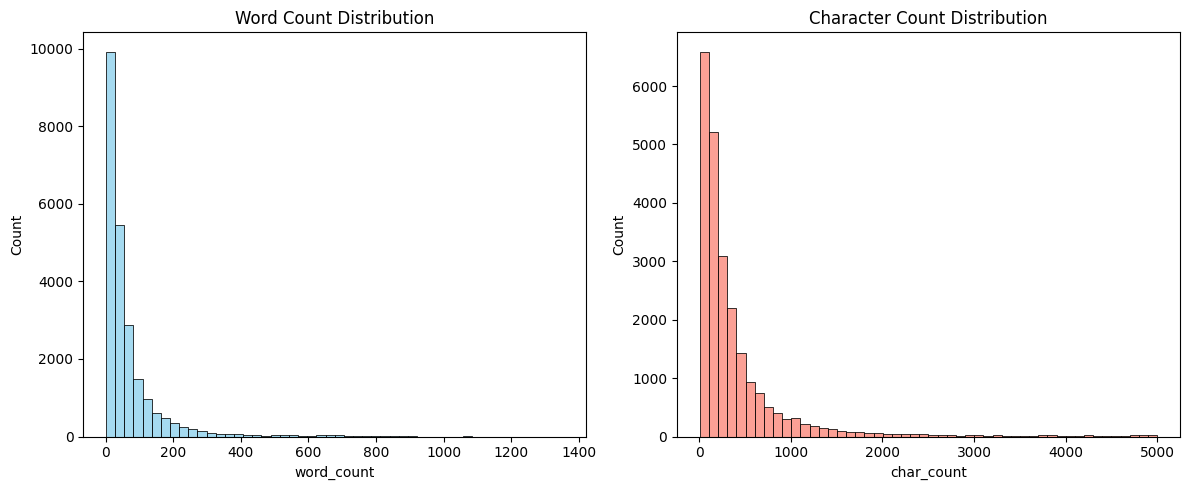

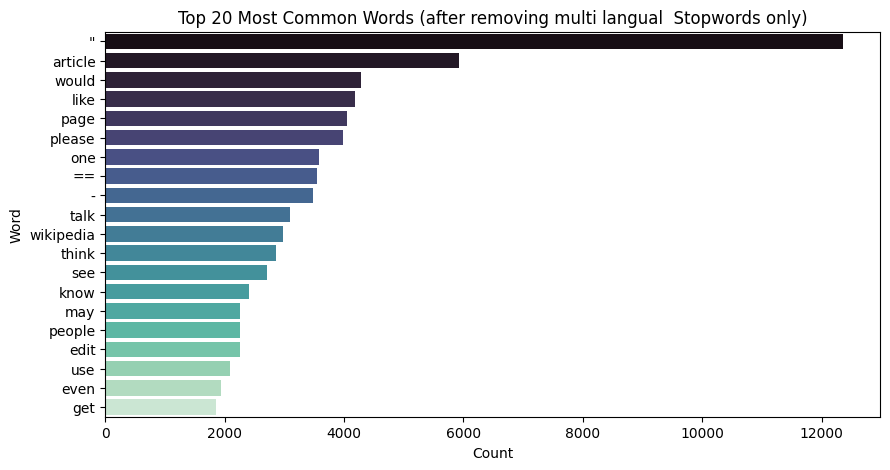

In [22]:

# Check for Missing Values
print("Missing values:\n", train.isnull().sum())

# Plot bar chart for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts >= 0]  

if not missing_counts.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_counts.index, y=missing_counts.values, palette="rocket")
    plt.title("Missing Values per Column")
    plt.ylabel("Number of Missing Values")
    plt.xlabel("Column Name")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Drop rows with missing feedback_text if any
missing_texts = train[train['feedback_text'].isnull()]
print(f"\nRows with missing feedback_text: {len(missing_texts)}")
if len(missing_texts) > 0:
    train = train.dropna(subset=['feedback_text'])

# Word Distribution and Sentence Length

train['word_count'] = train['feedback_text'].apply(lambda x: len(str(x).split()))
train['char_count'] = train['feedback_text'].apply(lambda x: len(str(x)))

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train['word_count'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('Word Count Distribution')

sns.histplot(train['char_count'], bins=50, ax=axes[1], color='salmon')
axes[1].set_title('Character Count Distribution')
plt.tight_layout()
plt.show()

# Most Common Words (Before Preprocessing)


# Get the list of English stopwords
# Remove stop words from feedback_text
all_words = ' '.join(train['feedback_text'].astype(str)).lower().split()
filtered_words = [word for word in all_words if word not in multi_stop_words]

# Count the most common words
common_words = Counter(filtered_words)
common_words_df = pd.DataFrame(common_words.most_common(20), columns=['word', 'count'])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=common_words_df, x='count', y='word', palette='mako')
plt.title("Top 20 Most Common Words (after removing multi langual  Stopwords only)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


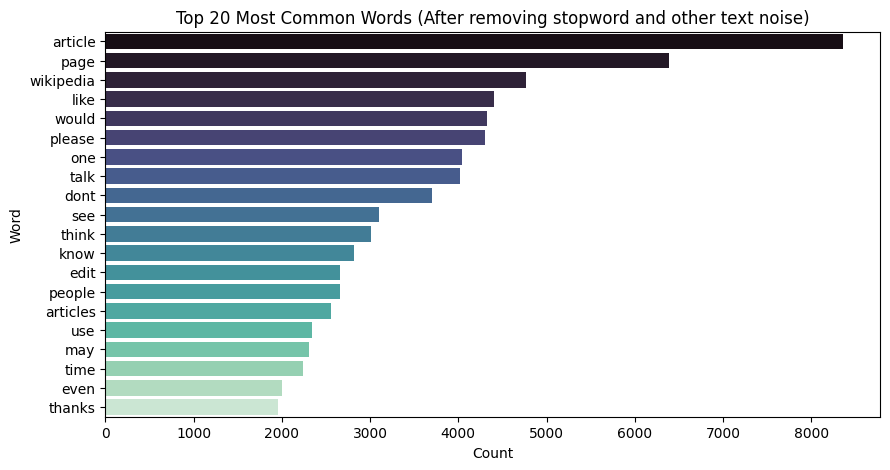

In [23]:


# Function to clean the text (remove stopwords, punctuation, numbers, etc.)
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation using str.translate
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers and special characters using regular expressions
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    words = text.split()
    cleaned_words = [word for word in words if word not in multi_stop_words ]

    return ' '.join(cleaned_words)

# Apply the clean_text function to the feedback_text column
train['cleaned_feedback_text'] = train['feedback_text'].apply(lambda x: clean_text(str(x)))

# Combine all cleaned words
all_words = ' '.join(train['cleaned_feedback_text']).split()

# Count the most common words
common_words = Counter(all_words)
common_words_df = pd.DataFrame(common_words.most_common(20), columns=['word', 'count'])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=common_words_df, x='count', y='word', palette='mako')
plt.title("Top 20 Most Common Words (After removing stopword and other text noise)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


<h1 style="color: green;"> Word Frequency Map  </h1>

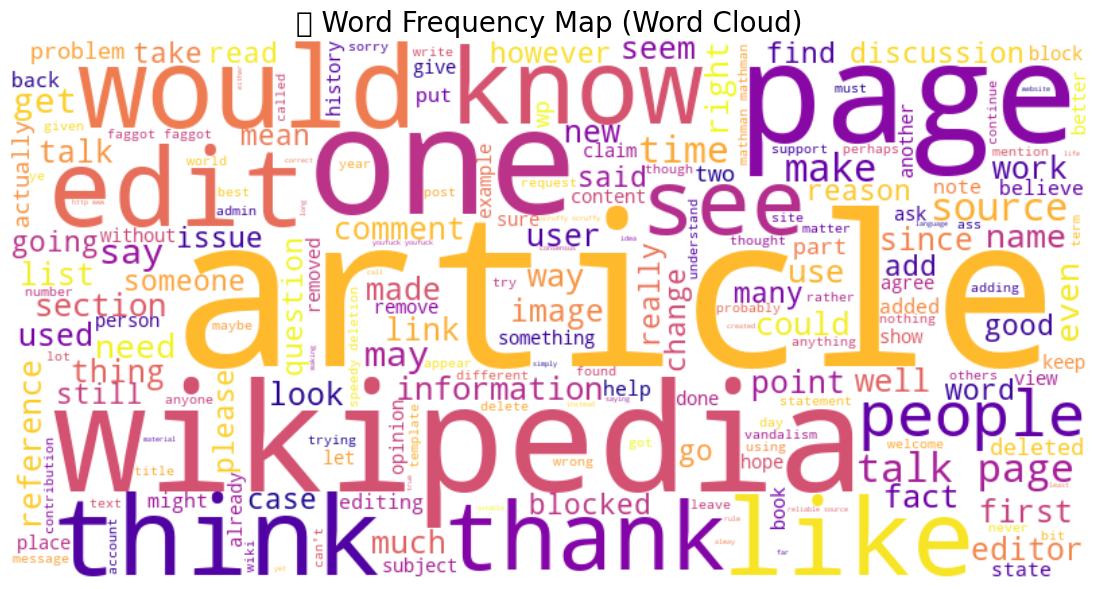

In [24]:
from wordcloud import WordCloud

# Combine all feedback_text into one string
all_text = ' '.join(train['feedback_text'].astype(str)).lower()

# Generate Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=multi_stop_words,
    max_words=200,
    colormap='plasma'
).generate(all_text)

# Plot Word Cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("🔤 Word Frequency Map (Word Cloud)", fontsize=20)
plt.show()


<h1> balancing the  dataset </h1>

In [ ]:
#badly needed but donot get time to do it 

<h1>preprocessing , training , evaluation <h1>

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



📊 Evaluation on Validation Set (toxic only):
Accuracy: 0.9621
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4241
           1       0.94      0.65      0.77       453

    accuracy                           0.96      4694
   macro avg       0.95      0.82      0.87      4694
weighted avg       0.96      0.96      0.96      4694

AUC-ROC: 0.9442


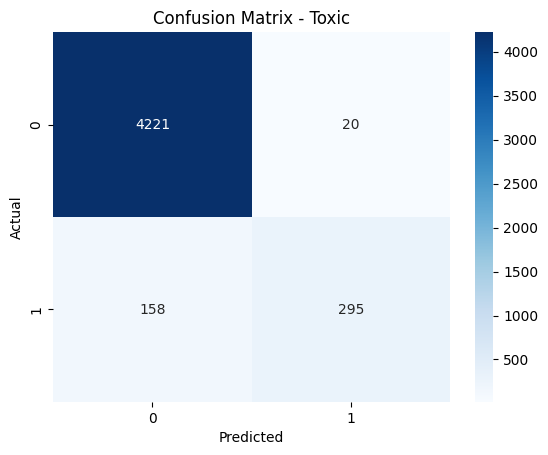

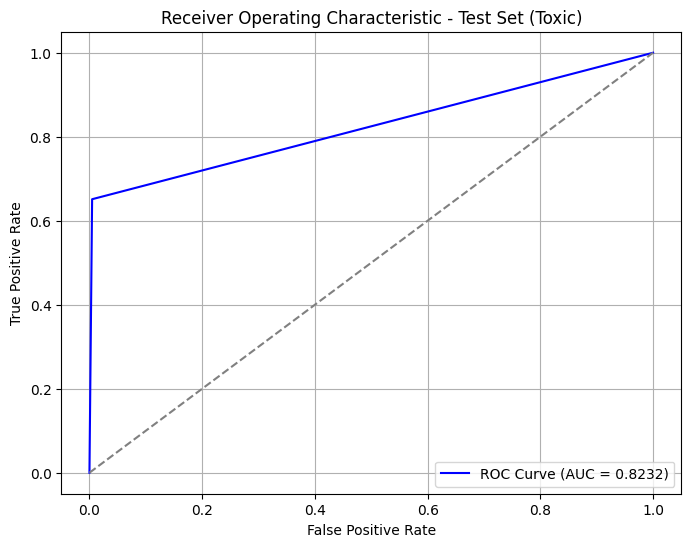

In [ ]:


# Setup
warnings.filterwarnings('ignore')
nltk.download('wordnet')



# Load Dataset
train_df = train
test_df = test  
# Preprocessing

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in multi_stop_words]
    return " ".join(tokens)

train_df['clean_text'] = train_df['feedback_text'].apply(preprocess)
test_df['clean_text'] = test_df['feedback_text'].apply(preprocess)

# ================================
# Custom Transformer for Metadata
# ================================
class MetadataExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns].values

# ================================
# Features & Labels
# ================================
text_features = train_df['clean_text']
text_test_features = test_df['clean_text']

meta_features = ['abusive', 'vulgar', 'menace', 'offense', 'bigotry']
train_df[meta_features] = train_df[meta_features].fillna(0)

# Fill missing with 0 in test if any of these columns are missing
for col in meta_features:
    if col not in test_df.columns:
        test_df[col] = 0

X = train_df[['clean_text'] + meta_features]
y = train_df['toxic']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ================================
# Pipeline
# ================================
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(max_features=10000), 'clean_text'),
    ('meta', StandardScaler(), meta_features)
])

pipeline = Pipeline([
    ('features', preprocessor),
    ('clf', LogisticRegression(solver='liblinear'))
])


# Train Model

pipeline.fit(X_train, y_train)


# Evaluate on Validation Set

y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

print("\n📊 Evaluation on Validation Set (toxic only):")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba):.4f}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Toxic")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set (Toxic)')
plt.legend(loc='lower right')
plt.grid()
plt.show()




📊 Evaluation on Test Set (toxic only):
Accuracy: 0.7727
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4637
           1       0.00      0.00      0.00      1363

    accuracy                           0.77      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.60      0.77      0.67      6000

AUC-ROC: 0.5078


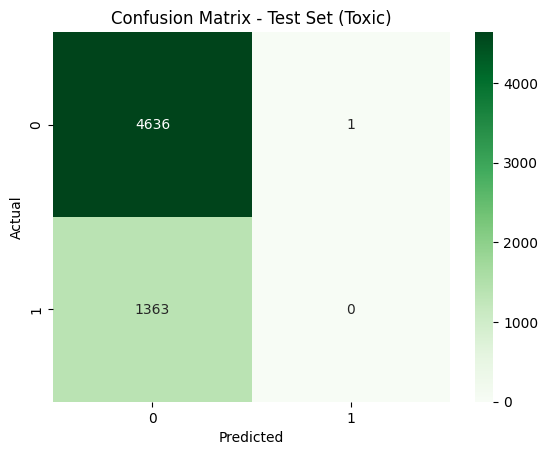

In [ ]:

# Predict and evaluation on Test Set

Y_test = test_df['toxic']
X_test = test_df[['clean_text'] + meta_features]
test_preds = pipeline.predict(X_test)
test_proba = pipeline.predict_proba(X_test)[:, 1]

# ✅ Evaluate on Test Set (if it has 'toxic' labels)
if 'toxic' in test_df.columns:
    print("\n📊 Evaluation on Test Set (toxic only):")
    print(f"Accuracy: {accuracy_score(Y_test, test_preds):.4f}")
    print(classification_report(Y_test, test_preds))
    print(f"AUC-ROC: {roc_auc_score(Y_test, test_proba):.4f}")
    
    # Confusion Matrix for Test Set
    sns.heatmap(confusion_matrix(Y_test, test_preds), annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix - Test Set (Toxic)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()




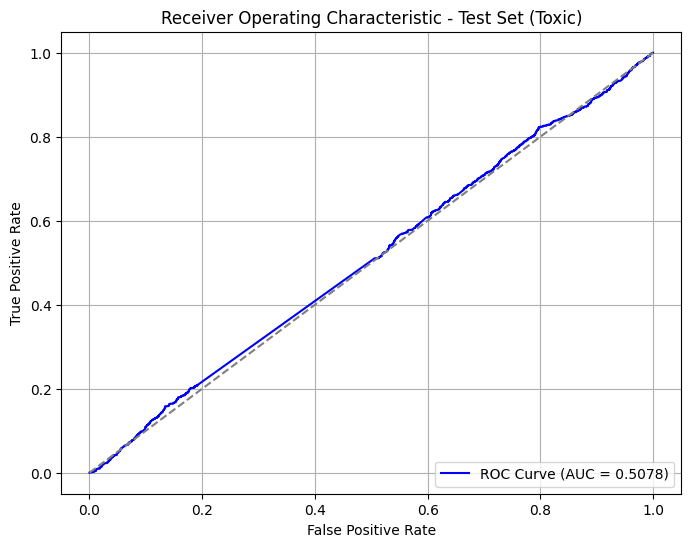

In [ ]:

# ROC Curve for test set (on test data)
fpr, tpr, thresholds = roc_curve(test_df['toxic'], test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set (Toxic)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


<h1> LSTM implementation </h1>

In [ ]:

# Preprocessing
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in multi_stop_words]
    return " ".join(tokens)

def simple_tokenizer(text):
    return text.split()

def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = simple_tokenizer(text)
        counter.update(tokens)
    vocab = {"<unk>": 0}
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = len(vocab)
    return vocab

def encode_tokens(tokens, vocab, max_len=100):
    token_ids = [vocab.get(token, 0) for token in tokens]
    return token_ids[:max_len] + [0]*(max_len - len(token_ids[:max_len]))

# Dataset Class
class CustomLSTMDataset(Dataset):
    def __init__(self, texts, labels=None, meta=None, vocab=None, max_len=100):
        self.texts = [encode_tokens(simple_tokenizer(t), vocab, max_len) for t in texts]
        self.labels = labels
        self.meta = meta

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.texts[idx], dtype=torch.long)
        }
        if self.meta is not None:
            item['meta'] = torch.tensor(self.meta[idx], dtype=torch.float)
        if self.labels is not None:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item
# Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, meta_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim + meta_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, meta):
        embeds = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(embeds)
        combined = torch.cat((hidden[-1], meta), dim=1)
        out = self.fc(combined)
        return self.sigmoid(out)
# Load and preprocess train data
train_df = train
train_df['clean_text'] = train_df['feedback_text'].apply(preprocess)

X = train_df['clean_text']
y = train_df['toxic'].values
meta = train_df[['abusive', 'vulgar', 'menace', 'offense', 'bigotry']].values
scaler = StandardScaler()
meta_scaled = scaler.fit_transform(meta)

X_train, X_val, y_train, y_val, meta_train, meta_val = train_test_split(
    X, y, meta_scaled, test_size=0.2, random_state=42
)

vocab = build_vocab(X_train)

train_dataset = CustomLSTMDataset(X_train, y_train, meta_train, vocab)
val_dataset = CustomLSTMDataset(X_val, y_val, meta_val, vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# ================================
# Train
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab), 100, 128, meta_dim=5, output_dim=1).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(25):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        meta = batch['meta'].to(device)
        labels = batch['label'].unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


# Evaluate

model.eval()
preds, probs, true = [], [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        meta = batch['meta'].to(device)
        labels = batch['label'].unsqueeze(1).to(device)
        outputs = model(input_ids, meta)
        probs.extend(outputs.cpu().numpy())
        preds.extend((outputs > 0.5).cpu().numpy())
        true.extend(labels.cpu().numpy())

true = np.array(true)
preds = np.array(preds)
probs = np.array(probs)

print("\nClassification Report (Validation - Toxic Only):")
print(classification_report(true, preds))
print("Accuracy:", accuracy_score(true, preds))
print("Precision:", precision_score(true, preds))
print("Recall:", recall_score(true, preds))
print("F1 Score:", f1_score(true, preds))
print("ROC AUC:", roc_auc_score(true, probs))
print("Confusion Matrix:\n", confusion_matrix(true, preds))
 
# Evaluate on Validation Set graph chart


print("\n📊 Evaluation on Validation Set (toxic only):")
print(f"Accuracy: {accuracy_score(true, preds):.4f}")
print(classification_report(true, preds))
print(f"AUC-ROC: {roc_auc_score(true, preds):.4f}")

# Confusion Matrix
sns.heatmap(confusion_matrix(true, preds), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Toxic")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AUC-ROC curve
fpr, tpr, thresholds = roc_curve(true, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set (Toxic)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
# ================================
# Test Prediction (toxic only)
# ================================
test_df = test
test_df['clean_text'] = test_df['feedback_text'].apply(preprocess)
test_meta = scaler.transform(test_df[['abusive', 'vulgar', 'menace', 'offense', 'bigotry']].values)

test_dataset = CustomLSTMDataset(test_df['clean_text'], meta=test_meta, vocab=vocab)
test_loader = DataLoader(test_dataset, batch_size=32)

model.eval()
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        meta = batch['meta'].to(device)
        outputs = model(input_ids, meta)
        predictions = (outputs > 0.5).int().cpu().numpy()
        test_preds.extend(predictions.flatten())



📊 Evaluation on Test Set (toxic only):
Accuracy: 0.7680
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      4637
           1       0.29      0.01      0.03      1363

    accuracy                           0.77      6000
   macro avg       0.53      0.50      0.45      6000
weighted avg       0.66      0.77      0.68      6000

AUC-ROC: 0.4995


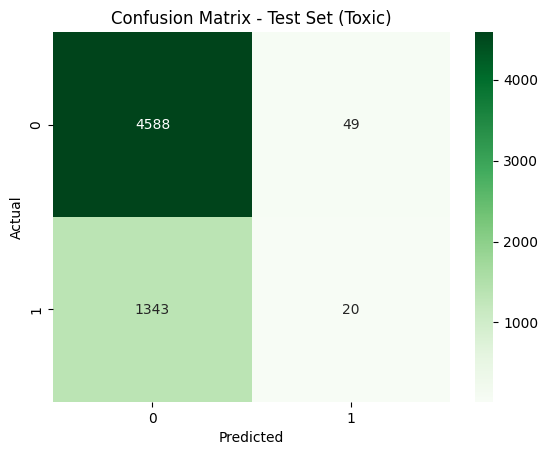

In [51]:
# Predict and evaluation on Test Set

Y_test = test_df['toxic']
model.eval()
T_preds, T_probs, T_true = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        meta = batch['meta'].to(device)
        
        outputs = model(input_ids, meta)
        T_probs.extend(outputs.cpu().numpy())
        T_preds.extend((outputs > 0.5).cpu().numpy())
        T_true.extend(labels.cpu().numpy())

T_true = np.array(T_true)
T_preds = np.array(T_preds)
T_probs = np.array(T_probs)


# ✅ Evaluate on Test Set (if it has 'toxic' labels)
if 'toxic' in test_df.columns:
    print("\n📊 Evaluation on Test Set (toxic only):")
    print(f"Accuracy: {accuracy_score(Y_test, T_preds):.4f}")
    print(classification_report(Y_test, T_preds))
    print(f"AUC-ROC: {roc_auc_score(Y_test, T_probs):.4f}")
    
    # Confusion Matrix for Test Set
    sns.heatmap(confusion_matrix(Y_test, T_preds), annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix - Test Set (Toxic)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

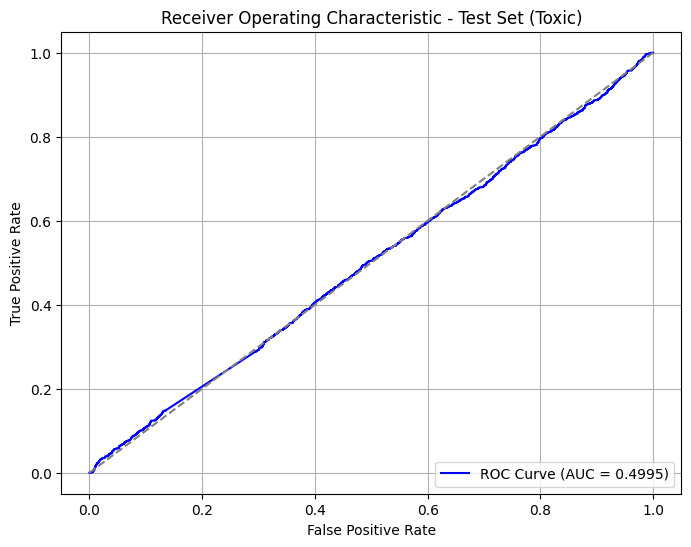

In [52]:

# ROC Curve for test set (on test data)
fpr, tpr, thresholds = roc_curve(test_df['toxic'], T_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set (Toxic)')
plt.legend(loc='lower right')
plt.grid()
plt.show()